In [63]:
import pandas as pd
import numpy as np
import os
import re

In [64]:
covid_data = pd.read_csv('data/covid_data.csv')

date — дата наблюдения;

province/state — наименование провинции/штата;

country — наименование страны;

confirmed — общее число зафиксированных случаев на указанный день;

deaths — общее число зафиксированных смертей на указанный день;

recovered — общее число выздоровлений на указанный день.

In [65]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

country — наименование страны;

date — дата наблюдения;

total_vaccinations — общее число введённых вакцин в стране на указанный день;

people_vaccinated — общее число привитых первым компонентом в стране на указанный день;

people_vaccinated_per_hundred — процент привитых первым компонентом в стране на указанный день (рассчитывается как );

people_fully_vaccinated — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);

people_fully_vaccinated_per_hundred — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );

daily_vaccination — ежедневная вакцинация (число вакцинированных в указанный день);

vaccines — комбинации вакцин, используемые в стране.

In [66]:
# Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. 
# Тем самым переходим от данных по регионам к данным по странам:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

In [67]:
# Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

covid_data['date'] = pd.to_datetime(covid_data['date'])

In [68]:
# Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

In [69]:
# Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
# Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём 
# группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [70]:
# В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [71]:
covid_df = pd.merge(
    covid_data,
    vaccinations_data,
    on=['date','country'],
    how='left'
)

In [72]:
covid_df['death_rate'] = (covid_df['deaths']/covid_df['confirmed'])*100
covid_df['recover_rate'] = (covid_df['recovered']/covid_df['confirmed'])*100

In [73]:
us_data = covid_df[covid_df['country'] == 'United States']

In [74]:
otvet = round(us_data['death_rate'].max(), 2)
display(otvet)

7.19

In [75]:
ru_data = covid_df[covid_df['country'] == 'Russia']

In [76]:
otvet = round(ru_data['recover_rate'].mean(), 2)
print(otvet)

67.06


# Основные параметры метода plot()

### x — название признака, который будет отложен по оси абсцисс;    
### y — название признака, который будет отложен по оси ординат;    
### figsize — размер графика (кортеж из ширины и высоты в дюймах);  
### kind —тип визуализации. Основные типы:                          
     'line' — линейный график (по умолчанию);
     'bar' — столбчатая диаграмма;
     'barh' — горизонтальная столбчатая диаграмма;
     'hist' — гистограмма;
     'box' — коробчатая диаграмма (boxplot);
     'pie' — круговая диаграмма;
     'scatter' — диаграмма рассеяния.
### grid — отображение сетки (по умолчанию False);
### legend — отображение легенды (по умолчанию False);
### title — название графика;
### color — цвет.


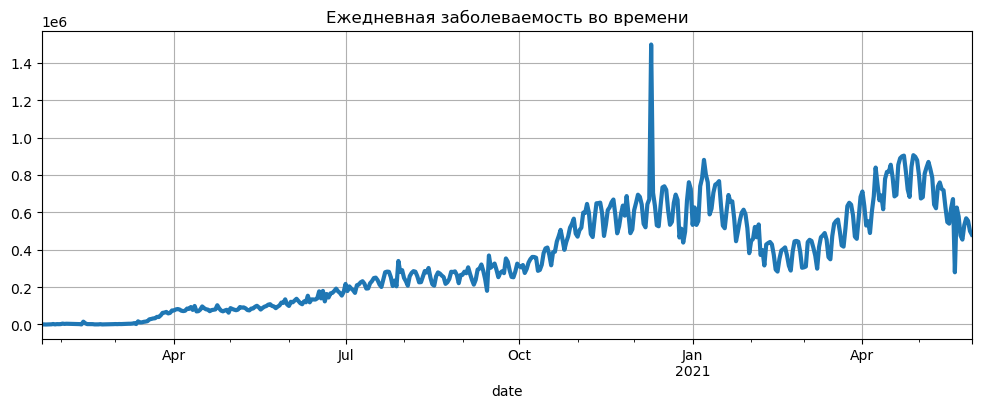

In [77]:
# Теперь мы наконец можем построить график с помощью метода plot(). 
# Будем использовать линейный график размером 12x4 (попробуйте взять другие числа, чтобы увидеть разницу). 
# Подпишем график и отобразим сетку. Параметр lw (line width) отвечает за ширину линии для линейного графика.
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
);

<AxesSubplot: title={'center': 'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

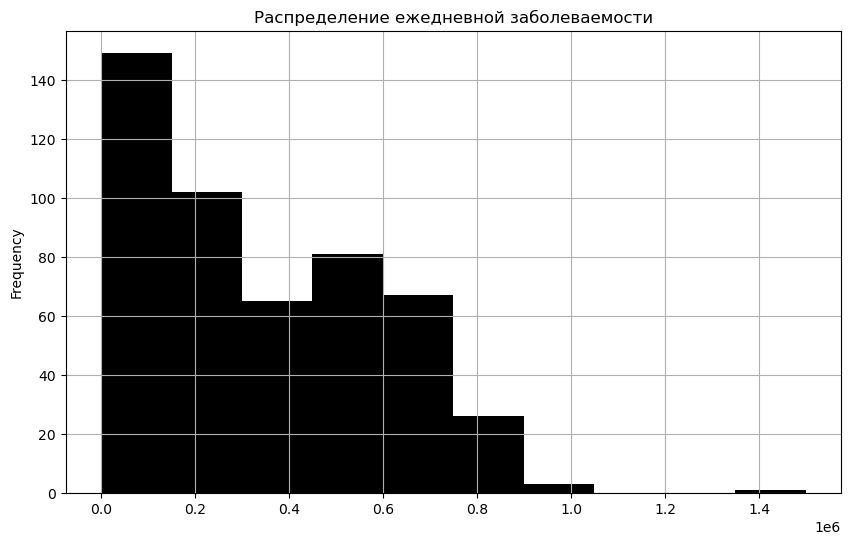

In [78]:
# Теперь построим гистограмму, которая покажет распределение ежедневной заболеваемости во всём мире. 
# Для этого параметр kind выставляем на значение 'hist'. Параметр bins (корзины) отвечает за число 
# прямоугольников в гистограмме — пусть их будет 10 (попробуйте использовать другие числа, чтобы увидеть разницу).

grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
)

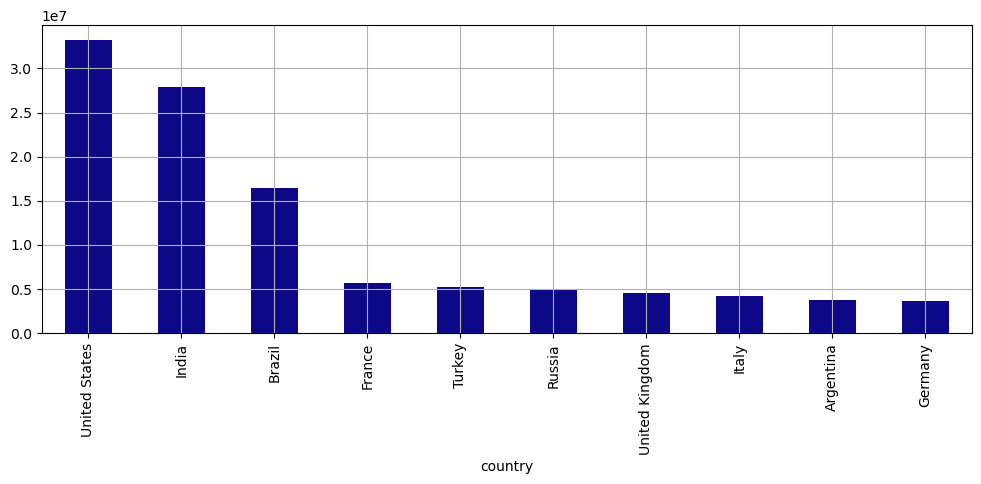

In [79]:
# Давайте построим столбчатую диаграмму, которая покажет ТОП-10 стран по суммарной заболеваемости.

# Для этого сгруппируем данные по странам и вычислим последний зафиксированный показатель с помощью агрегирующего 
# метода last() — он возвращает последнее значение в столбце DataFrame.

# Для построения столбчатой диаграммы значение параметра kind выставляем на 'bar'. Параметр colormap отвечает за цветовую гамму графика.

grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

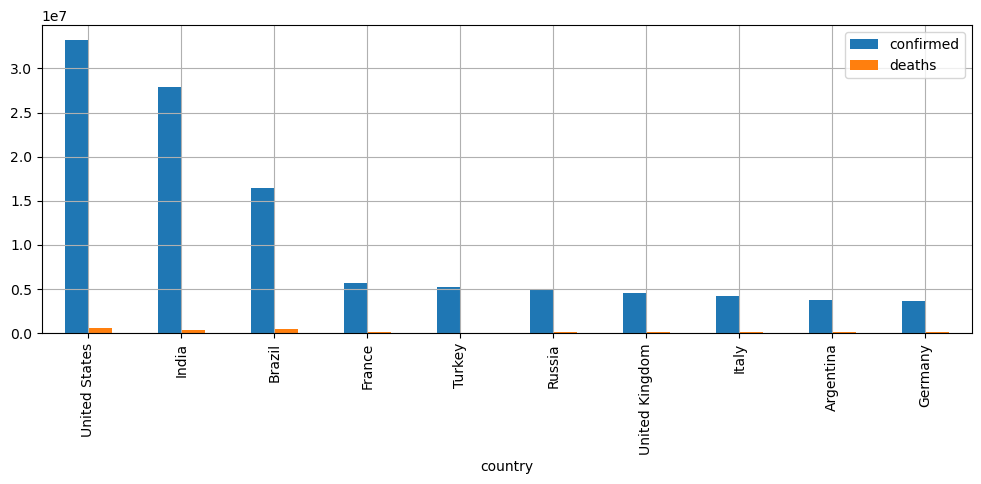

In [80]:
# А теперь посмотрим, как в этих десяти странах соотносится количество заболевших и умерших от вируса. 
# Для этого отобразим сразу два показателя на столбчатой диаграмме: 

grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(12, 4), );

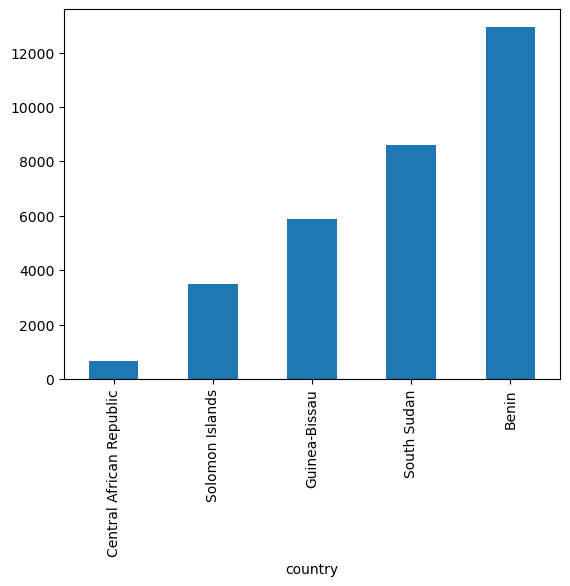

In [81]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

# Matplotlib — 
### это библиотека Python, обладающая большим количеством возможностей для визуализации и настройки отображения графиков и диаграмм.

In [83]:
# За визуализацию графиков в Matplotlib отвечает модуль pyplot. Традиционно он импортируется под псевдонимом plt. 
# Для более корректного отображения графиков в ноутбуках используется команда %matplotlib inline.

import matplotlib.pyplot as plt
%matplotlib inline

Примечание. 

In [84]:
# Если вы используете тёмную тему в VS Code, то для корректного отображения графиков на тёмном фоне выполните следующую команду по установке стиля отображения:

plt.style.use('default')

сначала создаётся объект фигуры (fig) , содержащий необходимую информацию и настройки, например размер в дюймах (figsize, восемь дюймов в ширину, четыре — в высоту). 
К этому объекту с помощью метода add_axes() добавляется координатная плоскость, а на ней располагаются графические объекты. 
Для создания координатной плоскости необходимо указать её расположение на фигуре в виде списка из координат. 
В нашем случае она начинается в левом нижнем углу без отступов (координаты 0, 0) и занимает всё отведённое место в области (100%, ширина и высота равны 1).

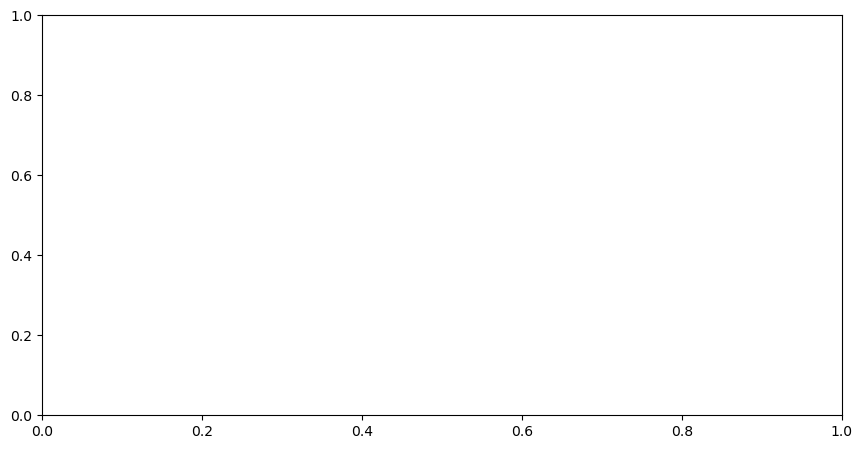

In [85]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

### Основные параметры метода scatter()

x, y — последовательности, которые будут отложены по осям абсцисс и ординат;

s — размер маркеров;

marker — вид маркеров ('o' — точки, '^' — треугольники);

c — цвет маркеров.

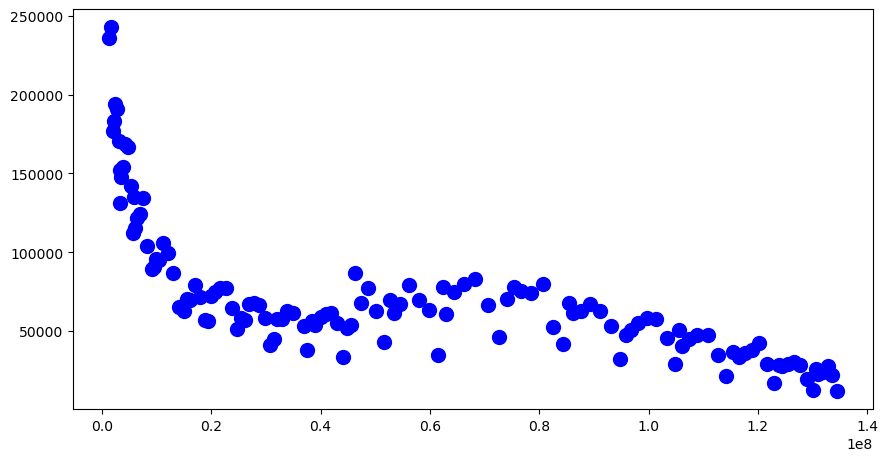

In [86]:
# На диаграмме рассеяния по оси абсцисс откладываем суммарное число поставленных вакцин, а по оси ординат — ежедневный прирост заболевших:

us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

### Основные параметры метода pie()

x — значения, по которым будет строиться круговая диаграмма;

labels — метки, соответствующие значениям;

autopct — формат отображения долей на диаграмме (например, '%.1f%%' означает, что округление будет производиться до первого знака после запятой и при выводе будет указан 
знак "%"; открывающий и закрывающий проценты означают форматирование, а внутренний — вывод знака "%");

explode — последовательность, которая определяет долю смещения сектора от центра для каждого значения из x.

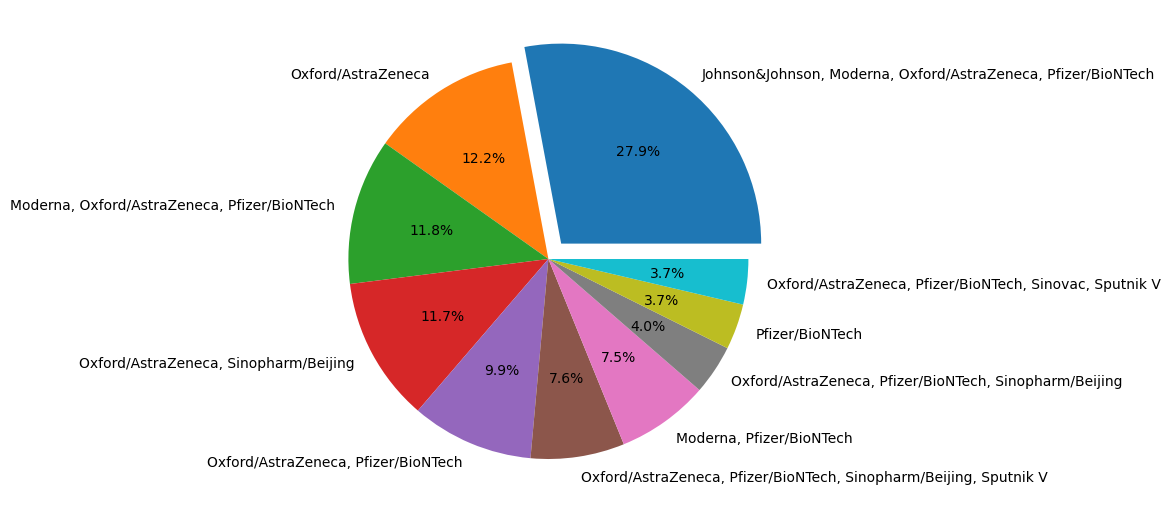

In [87]:
# ТОП-10 комбинаций вакцин (vaccines) по распространённости мы находим с помощью метода value_counts(). 
# Круговую диаграмму строим на полученных значениях, метки для каждого значения — индексы промежуточной таблицы. 
# Будем отображать доли в процентах и округлять их до одного знака после запятой. Самую распространённую вакцину сместим на 10 % от центра:

vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

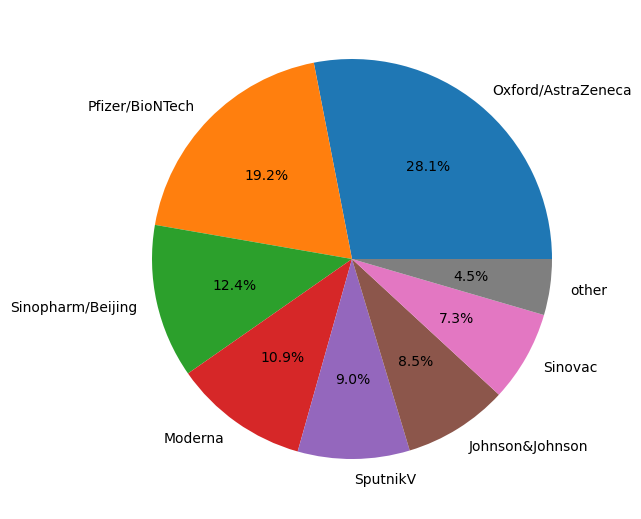

In [88]:
#избавляемся от пропусков в столбце с вакцинами
combination_not_nan = covid_df.dropna(subset=['vaccines'])
#группируем по странам и выбираем последнюю комбинацию вакцин в стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last() 
#заменяем пробелы в строках и делим комбинации на отдельные вакцины по запятой
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(',')) 
#создаём пустой словарь, ключами которого будут вакцины, а значениями — количество стран
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
#преобразуем словарь в Series
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
#выделяем ТОП-7 вакцин и добавляем категорию 'other'
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
#строим круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);

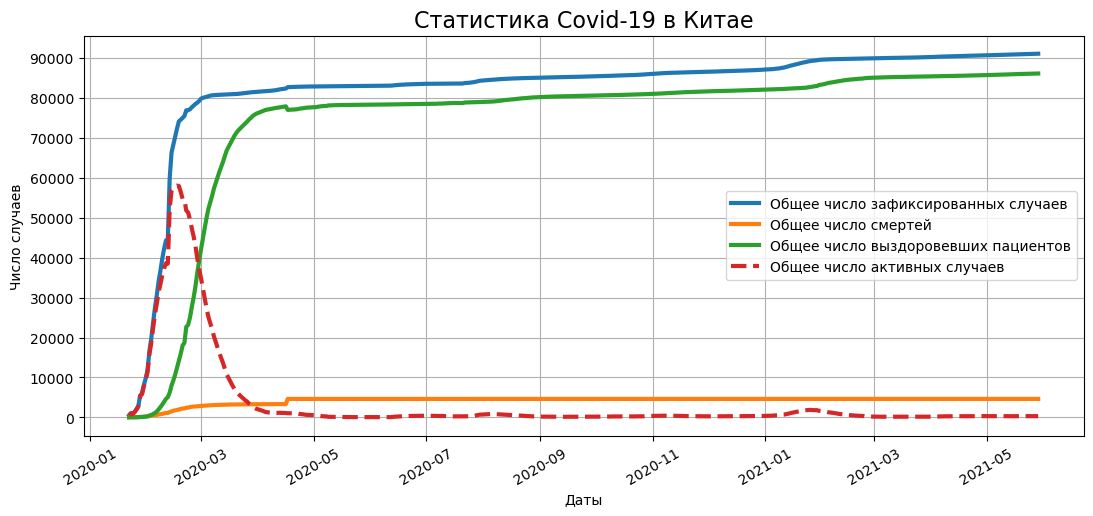

In [89]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

### Основные параметры метода bar()

x — названия категорий, которые будут располагаться по оси абсцисс;

height — высота столбцов диаграммы, массив из показателей для визуализации (например, среднее, максимальное значение и т. д.);

width — ширина столбцов диаграммы;

color — цвет.

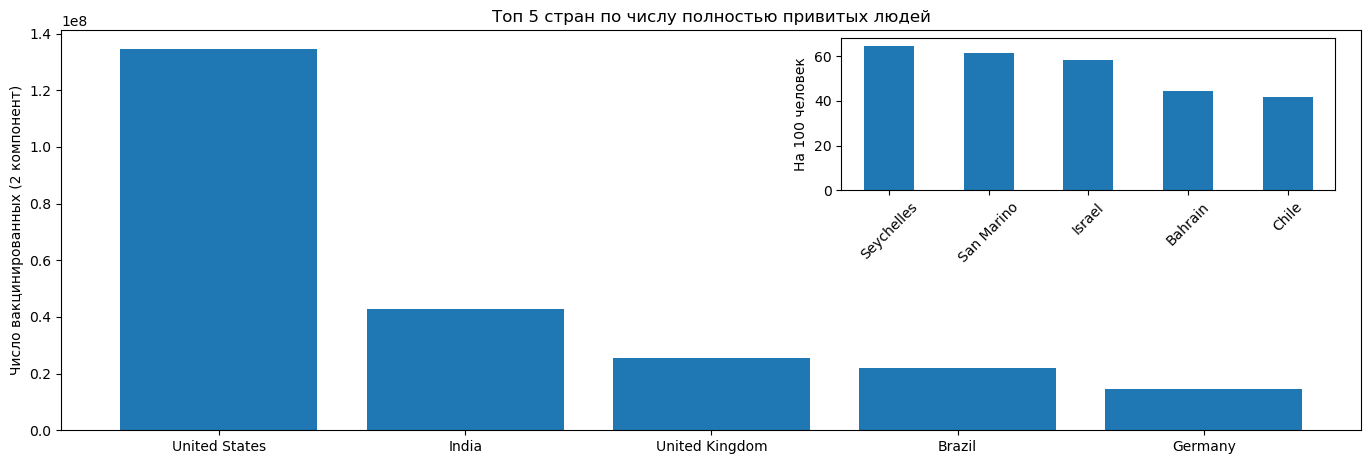

In [90]:
# Группируем таблицу по странам, находим последний по дате зафиксированный показатель с помощью метода last() 
# и выбираем ТОП-5 стран с использованием метода nlargest().
# При отображении графиков создаём две координатные плоскости main_axes и insert_axes, на каждой из них отдельно строим столбчатые диаграммы.

vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

### Основные параметры метода subplots()

nrows — число строк;

ncols — число столбцов;

figsize — общий размер фигуры в дюймах (ширина и высота).

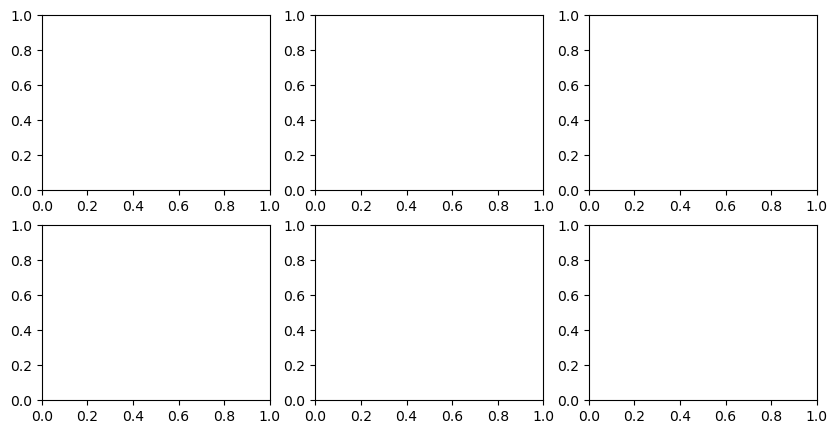

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

### Основные параметры метода hist()

x — массив чисел, для которого строится гистограмма;

bins — число столбцов (корзин);

orientation — ориентация гистограммы (по умолчанию 'vertical');

color — цвет.

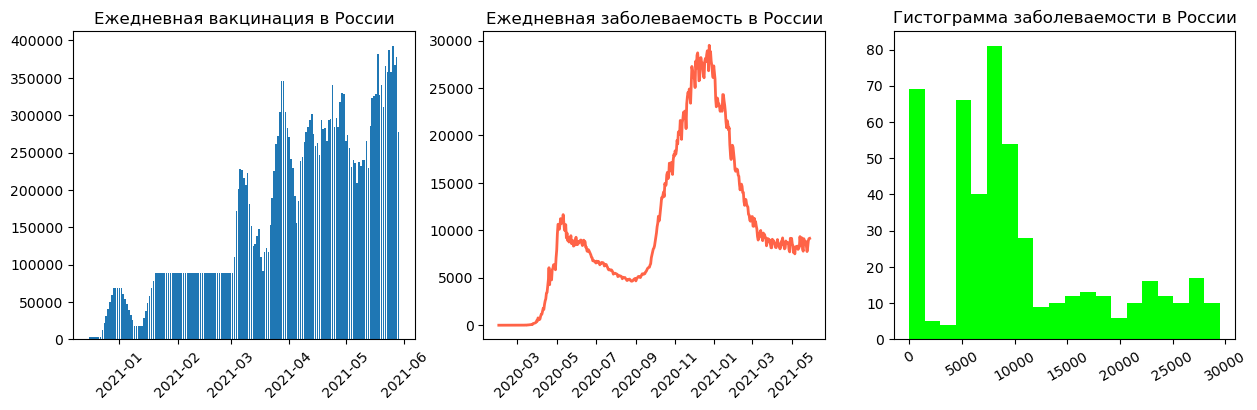

In [92]:
# Фильтруем таблицу covid_df по признаку страны и выбираем записи только для России.

# Для того чтобы отобразить график в соответствующей координатной плоскости, нужно обратиться к списку axes по индексу (от 0 до 2). 
# Дальнейшая настройка графиков вам уже известна.

russia_data = covid_df[covid_df["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)

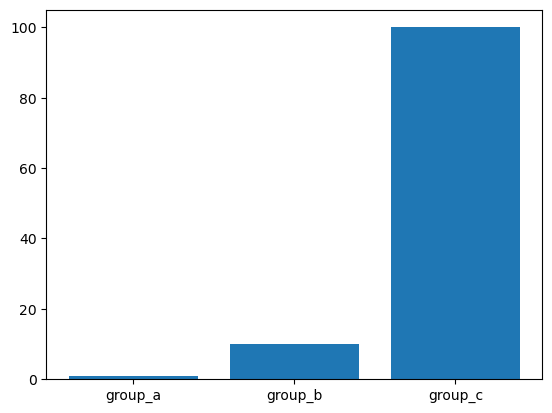

In [93]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]
plt.bar(names, values)
plt.show()

In [100]:
covid_df.to_csv('data/covid_df.csv', index=False)